In [5]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng
from sklearn.decomposition import PCA
from matplotlib import cm

import pickle as pck
import math

import sympy as sp
from mpl_toolkits.mplot3d import Axes3D

In [6]:
# potential
def Vpot(r):
    x, y = r
    return (x**2 - 1.5)**2 + .05 * (y**2) 

# dV/dx
def dVdx(r):
    x,y = r
    return 2* (x ** 2 - 1.5)* 2 * x

# dV/dy
def dVdy(r):
  x,y = r
  return .1 * y    
# compute kinetic energy

def Ekin(v, m=1.0):
    vx, vy = v
    v_mag_squared = vx ** 2 + vy ** 2
    return .5 * m * (v_mag_squared)

# check if particle is in A or B
def in_A(r):
    x, y = r
    return x < -.8
    
def in_B(r):
    x, y = r
    return x > .8

def get_region(r):
    x, y = r
    if in_A(r):
        return 'A'
    elif in_B(r):
        return 'B'
    return 'C'

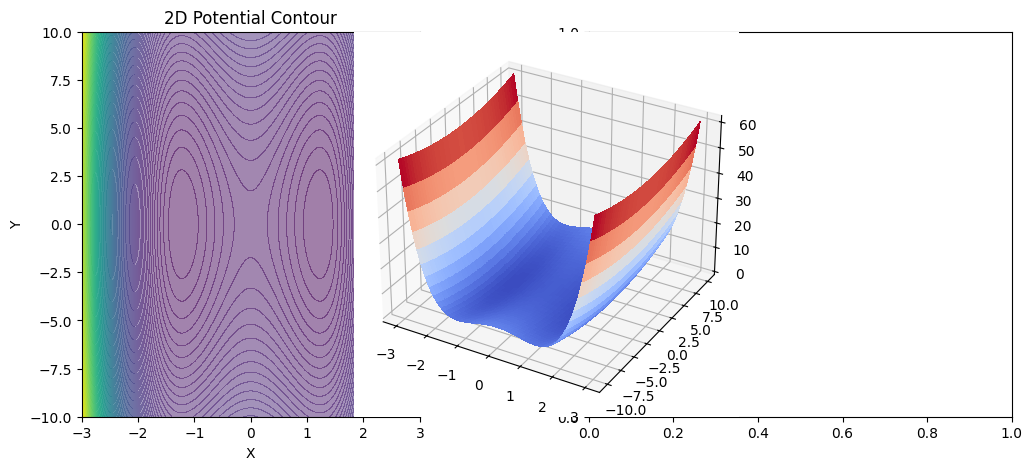

In [7]:
nx = 1000
ny = 1000
x = np.linspace(-3, 3, nx)
y = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x,y)
z = [Vpot([x_val, y_val]) for x_val, y_val in zip(xv,yv)]
z_grid = np.array(z).reshape(xv.shape)
# fig = plt.figure() 
# plt.contourf(x,y,z_grid, alpha=.5)



fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
ax1, ax2 = axes
contour2d = ax1.contourf(x,y,z_grid, alpha=.5, levels=200)
fig.colorbar(contour2d, ax=ax1, shrink=0.5, aspect=5)  # Add colorbar
ax1.set_title("2D Potential Contour")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

# contour3d = ax2.contour3D(xv, yv, z_grid, 200, cmap='viridis')  # 200 levels for smooth contours

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xv, yv, z_grid, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

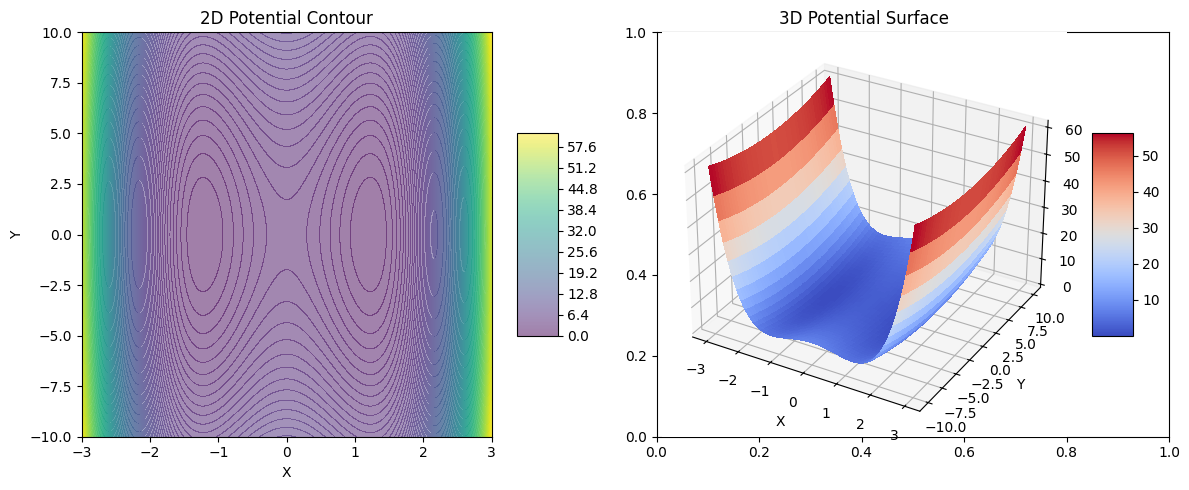

In [8]:
# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
ax1, ax2 = axes

# Plot 2D contour plot in ax1
contour2d = ax1.contourf(x, y, z_grid, alpha=0.5, levels=200)
fig.colorbar(contour2d, ax=ax1, shrink=0.5, aspect=5)  # Add colorbar
ax1.set_title("2D Potential Contour")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")

# Plot 3D surface plot in ax2 (use the second subplot for 3D)
ax2 = fig.add_subplot(122, projection='3d')  # 'projection' set to '3d' for 3D plot
surf = ax2.plot_surface(xv, yv, z_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Add colorbar to the 3D plot
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)

ax2.set_title("3D Potential Surface")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

# Show the plot
plt.tight_layout()
plt.show()

## MD step function

In [9]:
from numpy.random import default_rng
import numpy as np

# MD step
rng = default_rng(23)


def mdstep(r, v, f, dt, lc):
    """MD step using Langevin dynamics

    Parameters
    ----------
    r:
        positions
    v:
        velocities
    f:
        forces
    dt:
        time step
    lc:
        coefficients for Langevin dynamics

    Return
    ---------
    r:
        updated positions
    v:
        updated velocities
    f:
        updated forces

    """

    # mass is set to 1.0 here, does not explicitly appear in the equations

    # langevin thermo, 1st half step
    v = lc[0] * v + lc[1] * rng.standard_normal(size=2)

    # Verlet part of MD step
    v = v + 0.5 * f * dt
    r = r + dt * v

    # compute forces for new position, dVdx and dVdy are the partial derivatives wrt x and y
    f = np.array([-dVdx(r), -dVdy(r)])

    v = v + 0.5 * f * dt

    # langevin thermo, 2nd half step
    v = lc[0] * v + lc[1] * rng.standard_normal(size=2)

    return r, v, f

## Example for MD run

In [10]:
# set time step and temperature
dt = 0.05
beta = 4.0

# initialize random number generator
rng = default_rng(27)

# initialize langevin parameters
lgamma = 1.0
c1 = np.exp(-lgamma*dt/2.0)
c2 = np.sqrt((1.0-(c1*c1))/beta)
lc = np.array([c1,c2])

# initialize position, velocities, and forces
r = np.array([0.0,0.0])
v =np.array([np.sqrt(1.0/beta)*rng.standard_normal(),np.sqrt(1.0/beta)*rng.standard_normal()])
f = np.array([-dVdx(r), -dVdy(r)])

# rescale initial velocities to target temperature 
# you need to add the function to compute Ekin
scale = np.sqrt(1.0/beta/Ekin(v))
v = v*scale
print(f'Initial beta = {1.0/Ekin(v):.3f}')

sum_Ekin = 0.0
count = 0
positions = []
betas = []
for i in range(100000):
    for k in range(100):
        r,v,f = mdstep(r,v,f,dt,lc)
        count = count + 1
        sum_Ekin = sum_Ekin + Ekin(v)
    # add function in_A(r) and in_B(r) to determine if system is in A or B
    positions.append(r)
    betas.append(1.0/Ekin(v))
    if i % 100 == 0:
        print(i)
    # print(f'x = {r[0]:.3f}, y = {r[1]:.3f}, average beta = {1.0/(sum_Ekin/count):.3f}, A = {in_A(r)}, B = {in_B(r)}')
    



Initial beta = 4.000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100

## 1 - 2d double well: Potential definition and visualisation

In [11]:
betas

[1.2386732022253948,
 3.767259253777798,
 1.998856491438823,
 14.817599913567765,
 570.2668366893918,
 8.059467548142715,
 5.846103168870011,
 7.030291814000966,
 3.91576929874266,
 18.819931340868205,
 1.2937116260625168,
 2.673831763307099,
 21.880789263903445,
 12.230554298098264,
 2.822389974331536,
 20.513603256048366,
 2.885876681203808,
 112.98083991799948,
 4.6590816821393695,
 2.888647368180189,
 4.4734675358890765,
 7.434108605737047,
 3.221570659025384,
 12.90549986450705,
 1.8064127408072574,
 166.33017892057836,
 7.051024391051648,
 3.3792949314730008,
 5.9096495522979176,
 10.430223242751781,
 14.329965291357798,
 4.825749281821953,
 3.658155239986804,
 8.960325838758168,
 66.24259557937702,
 1.459437012956304,
 1.7309591857682347,
 2.4943092843397054,
 1.7594516718772202,
 14.79355370781867,
 34.38097293672217,
 4.652565659781064,
 1.2918470240650555,
 28.65327980680717,
 15.855919205291437,
 4.083938156629449,
 11.927899847639534,
 6.884731638384618,
 5.142789642433029,

In [12]:
# positions



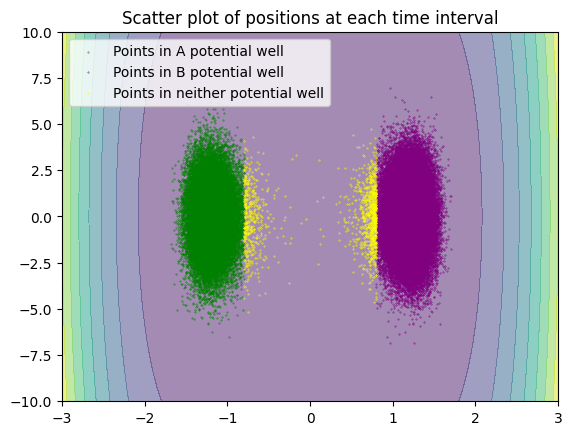

In [13]:
nx = 100
ny = 100
x = np.linspace(-3, 3, nx)
y = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x,y)
z = [Vpot([x_val, y_val]) for x_val, y_val in zip(xv,yv)]
z_grid = np.array(z).reshape(xv.shape)
fig = plt.figure() 
plt.contourf(x,y,z_grid, alpha=.5)

positions = np.array(positions)

# Extract x and y coordinates
x_positions = positions[:, 0]
y_positions = positions[:, 1]

def decide_color(r):
  if in_A(r):
    return "purple"
  return "green"

colors = [decide_color(pos) for pos in positions]


A_positions = [ pos for pos in positions if in_A(pos)]
B_positions = [ pos for pos in positions if in_B(pos)]
C_positions = [pos for pos in positions if (not (in_A(pos) or in_B(pos)))]

xA_positions = [arr[0] for arr in A_positions]
xB_positions = [arr[0] for arr in B_positions]
yA_positions = [arr[1] for arr in A_positions]
yB_positions = [arr[1] for arr in B_positions]
xC_positions = [arr[0] for arr in C_positions]
yC_positions = [arr[1] for arr in C_positions]


# plt.scatter(x_positions, y_positions, color=colors, label='Points', zorder=3, s=.01)

plt.scatter(xA_positions, yA_positions, color="green", label='Points in A potential well', zorder=3, s=.1)
plt.scatter(xB_positions, yB_positions, color="purple", label='Points in B potential well', zorder=3, s=.1)
plt.scatter(xC_positions, yC_positions, color="yellow", label='Points in neither potential well', zorder=3, s=.1)




plt.legend(loc='upper left')
plt.title("Scatter plot of positions at each time interval")
plt.show()


In [14]:
# B_positions


/var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/ipykernel_29140/1183082576.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


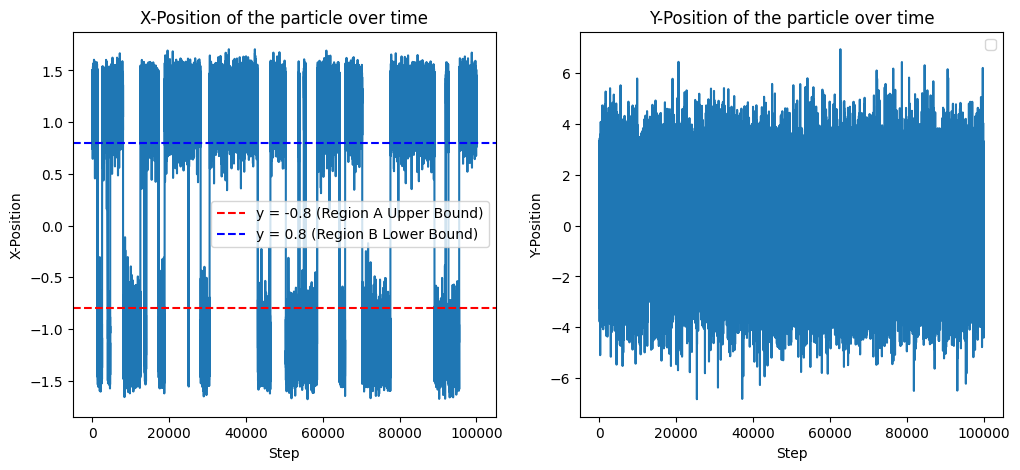

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns
ax1, ax2 = axes

ax1.plot(range(len(x_positions)), x_positions)
ax1.set_xlabel('Step')
ax1.set_ylabel('X-Position')
ax1.set_title('X-Position of the particle over time')
ax1.axhline(y=-0.8, color='red', linestyle='--', label='y = -0.8 (Region A Upper Bound)')
ax1.axhline(y=0.8, color='blue', linestyle='--', label='y = 0.8 (Region B Lower Bound)')


ax2.plot(range(len(y_positions)), y_positions)
ax2.set_xlabel('Step')
ax2.set_ylabel('Y-Position')
ax2.set_title('Y-Position of the particle over time')

ax1.legend()
ax2.legend()

plt.show()

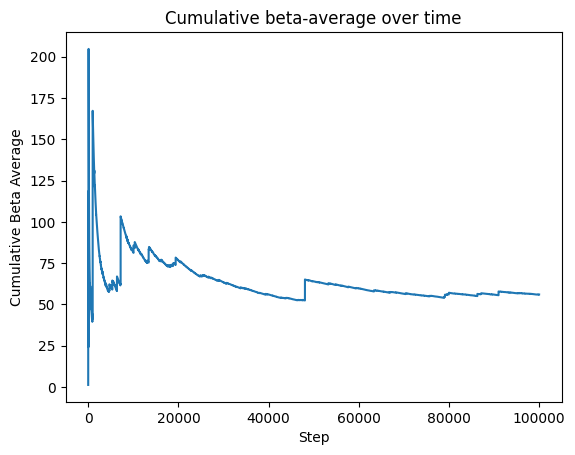

In [16]:
fig = plt.figure() 
cumulative_avg = np.cumsum(betas) / np.arange(1, len(betas) + 1)

plt.plot(range(len(cumulative_avg)), cumulative_avg)
plt.xlabel('Step')
plt.ylabel('Cumulative Beta Average')
plt.title('Cumulative beta-average over time')

plt.show()

## 1.3 - PCA


In [17]:
def pca(X, num_components):
    """ Performs PCA for a given number of components. Returns reduced data and eigenvectors (principal components).

    Parameters:
    -----------
    X : Array to perform PCA on.
    num_components : Number of principal components of interest.
    """
    # subtract mean
    x = X - np.mean(X, axis=0)

    # covariance matrix
    cov_mat = np.cov(x, rowvar=False)

    # Diagonalize covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov_mat)

    # Sort
    sorted_ids = np.argsort(eigvals)[::-1]
    eigvecs_sorted = eigvecs[:, sorted_ids]
    eigvals_sorted = eigvals[sorted_ids]

    # Select requested eigenvectors
    eigvecs_selected = eigvecs_sorted[:, 0:num_components]
    eigvals_selected = eigvals_sorted[0:num_components]


    # Project data onto eigenvectors
    X_projected = np.dot(eigvecs_selected.transpose(), x.transpose()).transpose()

    return X_projected, eigvecs_selected, eigvals_selected

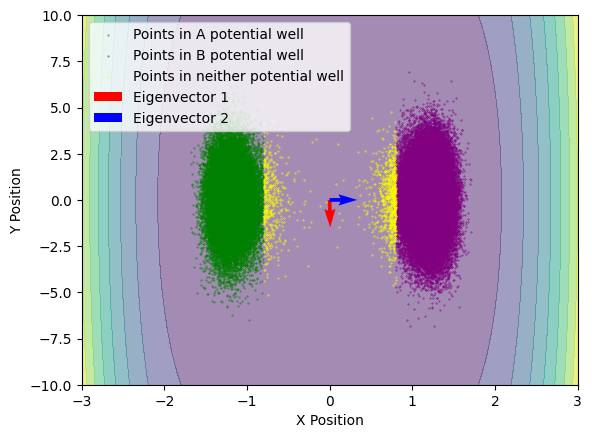

In [18]:
nx = 100
ny = 100
x = np.linspace(-3, 3, nx)
y = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x,y)
z = [Vpot([x_val, y_val]) for x_val, y_val in zip(xv,yv)]
z_grid = np.array(z).reshape(xv.shape)
fig = plt.figure() 
plt.contourf(x,y,z_grid, alpha=.5)

positions = np.array(positions)

# Extract x and y coordinates
x_positions = positions[:, 0]
y_positions = positions[:, 1]

def decide_color(r):
  if in_A(r):
    return "purple"
  return "green"

colors = [decide_color(pos) for pos in positions]
A_positions = [ pos for pos in positions if in_A(pos)]
B_positions = [ pos for pos in positions if in_B(pos)]
C_positions = [pos for pos in positions if (not (in_A(pos) or in_B(pos)))]

xA_positions = [arr[0] for arr in A_positions]
xB_positions = [arr[0] for arr in B_positions]
yA_positions = [arr[1] for arr in A_positions]
yB_positions = [arr[1] for arr in B_positions]
xC_positions = [arr[0] for arr in C_positions]
yC_positions = [arr[1] for arr in C_positions]


# plt.scatter(x_positions, y_positions, color=colors, label='Points', zorder=3, s=.01)

plt.scatter(xA_positions, yA_positions, color="green", label='Points in A potential well', zorder=3, s=.1)
plt.scatter(xB_positions, yB_positions, color="purple", label='Points in B potential well', zorder=3, s=.1)
plt.scatter(xC_positions, yC_positions, color="yellow", label='Points in neither potential well', zorder=3, s=.1)

# plt.show()


_, eigenvectors, eigenvalues = pca(positions, 2)
eigenvectors[0] /= np.linalg.norm(eigenvectors[0]) 
eigenvectors[1] /= np.linalg.norm(eigenvectors[1]) 

for i in range(len(eigenvalues)):
  eigenvector = eigenvectors[i]
  plt.quiver(
          0, 0,  # Start point
          eigenvector[0], eigenvector[1],  # Direction
          # scale=eigenvalues[i], 
          scale_units='xy', angles='xy', color=['r', 'b'][i],
          label=f"Eigenvector {i+1}"
      )
plt.legend(loc='upper left')
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("")
plt.show()


In [19]:
# repeat using positions + KE or PE? + v?
eigenvectors

array([[ 0.00469273, -0.99998899],
       [ 0.99998899,  0.00469273]])

In [20]:
eigenvectors[0] /= np.linalg.norm(eigenvectors[0])
eigenvectors[1] /= np.linalg.norm(eigenvectors[1])
eigenvectors

array([[ 0.00469273, -0.99998899],
       [ 0.99998899,  0.00469273]])

In [21]:
eigenvalues

array([2.49777529, 1.33490945])

![Alt Text](./var/folders/y9/lzm82l3943n1ly680x98vpm40000gn/T/TemporaryItems/NSIRD_screencaptureui_BukdAd/Screenshot 2024-11-21 at 21.43.24.png)

In [22]:
# Part 2
# potential

x, y = sp.symbols('x y')
V = (x**4 + y**4) / 20480 - 3 *  sp.exp(-0.01 * ((x+5)**2) - 0.2 * ((y+5) ** 2)) - 3 * sp.exp(-0.01 * ((x - 5) ** 2) - 0.2 * ((y - 5) ** 2)) \
  + 5 * sp.exp(-0.2 * ((x + 3 * (y - 3)) ** 2)) / (1 + sp.exp(-1 * x - 3)) + 5 * sp.exp(-0.2 * (x + 3*(y + 3)) ** 2) / (1 + sp.exp(x - 3)) \
  + 3 * sp.exp(-0.01*(x ** 2 + y ** 2))

V_function = sp.lambdify((x, y), V)

def Vpot2(r):
  x0, y0 = r
  return V_function(x0, y0)

# dV/dx
def dV2dx(r):
    x0,y0 = r
    return sp.lambdify((x, y), sp.diff(V, x))(x0, y0)

# dV/dy
def dV2dy(r):
  x0,y0 = r
  return sp.lambdify((x, y), sp.diff(V, y))(x0, y0)
#   line11 =  x ** 4 / 20480 - 3 * math.exp(-0.01 * ((x+5)**2) - 0.2 * ((y+5) ** 2)) * -0.01 * ((x+5)* 2)
#   line12 = 3 * math.exp(-0.01 * ((x - 5) ** 2) - 0.2 * ((y - 5) ** 2)) * -0.01 * ((x - 5) * 2)
#   line21 = -(806.858 e^(x - 0.2 (-9 + x + 3 y)^2) (-0.572551 + 0.0497871 x + 0.149361 y + e^x (-9 + x + 3 y)))/(1 + e^(3 + x))^2



# compute kinetic energy
 
def Ekin2(v, m=1.0):
    vx, vy = v
    v_mag_squared = vx ** 2 + vy ** 2
    return .5 * m * (v_mag_squared)

# check if particle is in A or B
def in_A2(r):
    x0, y0 = r
    return x0 < -4.0 and y0 < -3.0 
    
def in_B2(r):
    x0, y0 = r
    return x0 > 4.0 and y0 > 3.0

In [23]:
Vpot2([1,2])


4.638063222192308

In [24]:
# set time step and temperature
dt2 = 0.05
beta2 = 1.5

# initialize random number generator
rng2 = default_rng(27)

# initialize langevin parameters
lgamma2 = 1.0
c1 = np.exp(-lgamma2*dt2/2.0)
c2 = np.sqrt((1.0-(c1*c1))/beta2)
lc = np.array([c1,c2])

# initialize position, velocities, and forces
r = np.array([0.0,0.0])
v =np.array([np.sqrt(1.0/beta2)*rng2.standard_normal(),np.sqrt(1.0/beta2)*rng.standard_normal()])
f = np.array([-dV2dx(r), -dV2dy(r)])

# rescale initial velocities to target temperature 
# you need to add the function to compute Ekin
scale = np.sqrt(1.0/beta2/Ekin2(v))
v = v*scale
print(f'Initial beta = {1.0/Ekin2(v):.3f}')

sum_Ekin = 0.0
count = 0
positions2 = []
for i in range(10000):
    for k in range(100):
        r,v,f = mdstep(r,v,f,dt,lc)
        count = count + 1
        sum_Ekin = sum_Ekin + Ekin2(v)
    # add function in_A(r) and in_B(r) to determine if system is in A or B
    positions2.append(r)
    # print(f'x = {r[0]:.3f}, y = {r[1]:.3f}, average beta = {1.0/(sum_Ekin/count):.3f}, A = {in_A(r)}, B = {in_B(r)}')
    


Initial beta = 1.500


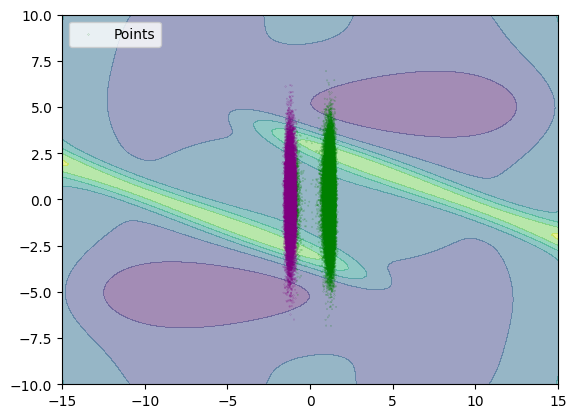

In [25]:



nx = 100
ny = 100
x = np.linspace(-15, 15, nx)
y = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x,y)
z = [Vpot2([x_val, y_val]) for x_val, y_val in zip(xv,yv)]
z_grid = np.array(z).reshape(xv.shape)
fig = plt.figure() 
plt.contourf(x,y,z_grid, alpha=.5)

positions = np.array(positions)

# Extract x and y coordinates
x_positions = positions[:, 0]
y_positions = positions[:, 1]

def decide_color(r):
  if in_A(r):
    return "purple"
  return "green"

colors = [decide_color(pos) for pos in positions]

plt.scatter(x_positions, y_positions, color=colors, label='Points', zorder=3, s=.01)
plt.legend(loc='upper left')
plt.show()